# clinvar-conflicting EDA

Explore some of the features in the ClinVar-conflicting dataset.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style(style='whitegrid')
sns.set(font_scale=1.5);

import pandas as pd

In [2]:
df = pd.read_csv('clinvar_conflicting.csv', dtype={0: object, 38: str, 40: object})

In [3]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


The `CLASS` distribution is skewed a bit to the `0` class, meaning there are fewer variants with conflicting submissions.

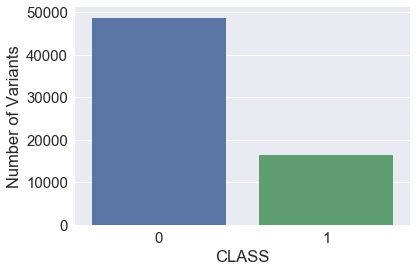

In [4]:
ax = sns.countplot(x="CLASS", data=df)
ax.set(xlabel='CLASS', ylabel='Number of Variants');

It's clear that conflicting variants are more common in some genes.   

In [5]:
gene_ct = pd.crosstab(df.SYMBOL, df.CLASS, margins=True)

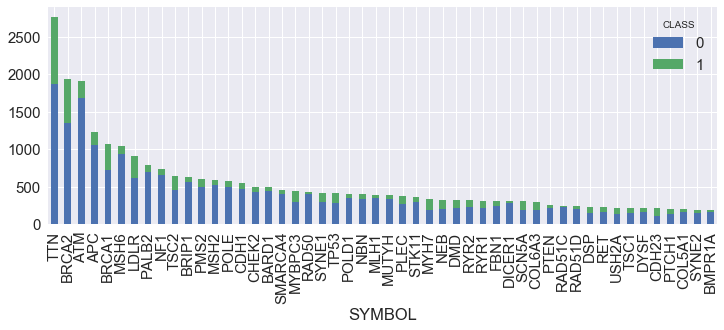

In [6]:
gene_ct = pd.crosstab(df.SYMBOL, df.CLASS, margins=True)
gene_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
gene_ct = gene_ct.sort_values(by='All', ascending=False).head(50)
gene_ct.drop('All', axis=1, inplace=True)

gene_ct.plot.bar(stacked=True, figsize=(12, 4));

CLNVC (Variant Type)

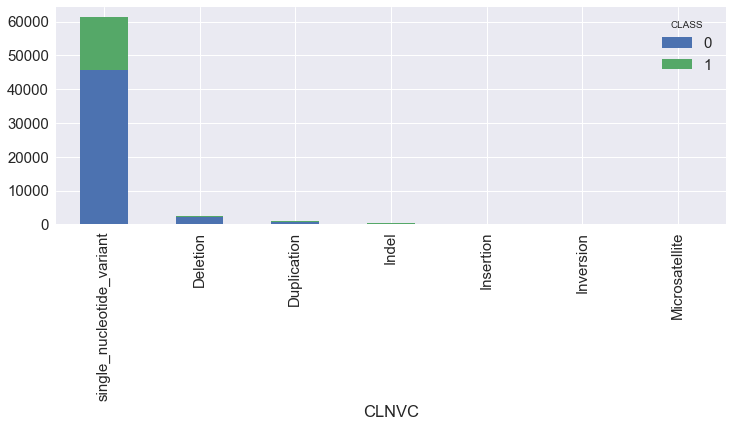

In [7]:
vt_ct = pd.crosstab(df.CLNVC, df.CLASS, margins=True)
vt_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
vt_ct = vt_ct.sort_values(by='All', ascending=False)
vt_ct.drop('All', axis=1, inplace=True)

vt_ct.plot.bar(stacked=True, figsize=(12, 4));

Parse and encode the `MC` (molecular consequence) field

In [8]:
MC_list = df.MC.dropna().str.split(',').apply(lambda row: list((c.split('|')[1] for c in row)))
MC_encoded = pd.get_dummies(MC_list.apply(pd.Series).stack()).sum(level=0)
MC_encoded = MC_encoded.reindex(index=MC_list.index)

# Incorporate the transformed MC feature into the existing DataFrame
df = df.join(MC_encoded).drop(columns=['MC'])

# Transformed MC feature
MC_encoded.head()

,2KB_upstream_variant,3_prime_UTR_variant,500B_downstream_variant,5_prime_UTR_variant,frameshift_variant,intron_variant,missense_variant,nonsense,splice_acceptor_variant,splice_donor_variant,synonymous_variant
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1


Manually generate the `crosstab`, there is probably a faster method via `pandas`.

In [9]:
mccounts= {0: {},
           1: {},
           'All': {}
          }

for col in MC_encoded.columns:
    for class_ in [0, 1]:
        mccounts[class_][col] = df.loc[df['CLASS'] == class_][col].sum()
    
    mccounts['All'][col] = df[col].sum()
    
mc_ct = pd.DataFrame.from_dict(mccounts)

mc_ct_all = mc_ct.sum(axis=0)
mc_ct_all.name = 'All'
mc_ct = mc_ct.append(mc_ct_all, ignore_index=False)

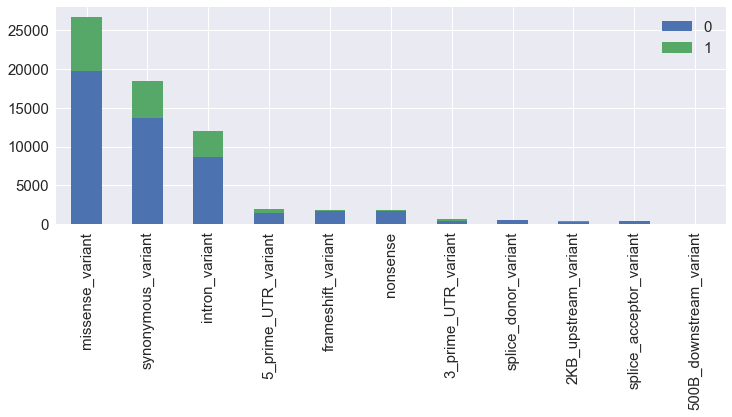

In [10]:
mc_ct.drop('All', axis=0, inplace=True)

mc_ct = mc_ct.sort_values(by='All', ascending=False)
mc_ct.drop('All', axis=1, inplace=True)

mc_ct.plot.bar(stacked=True, figsize=(12, 4));

Results from `SIFT` and `PolyPhen` software that predict the severity of a variant, in-silico.

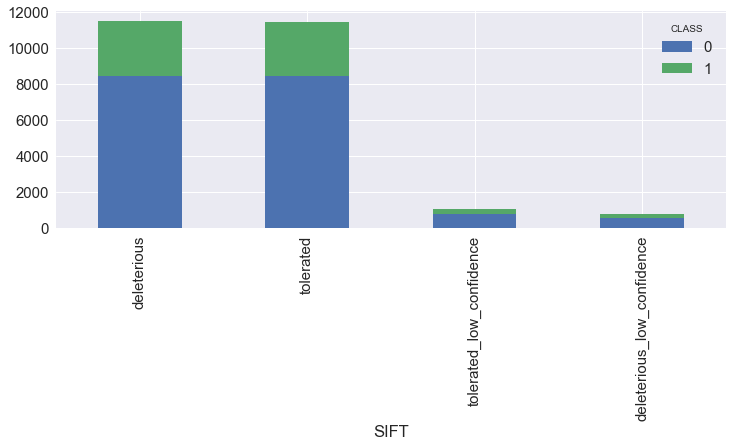

In [14]:
sift_ct = pd.crosstab(df.SIFT, df.CLASS, margins=True)
sift_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
sift_ct = sift_ct.sort_values(by='All', ascending=False)
sift_ct.drop('All', axis=1, inplace=True)

sift_ct.plot.bar(stacked=True, figsize=(12, 4));

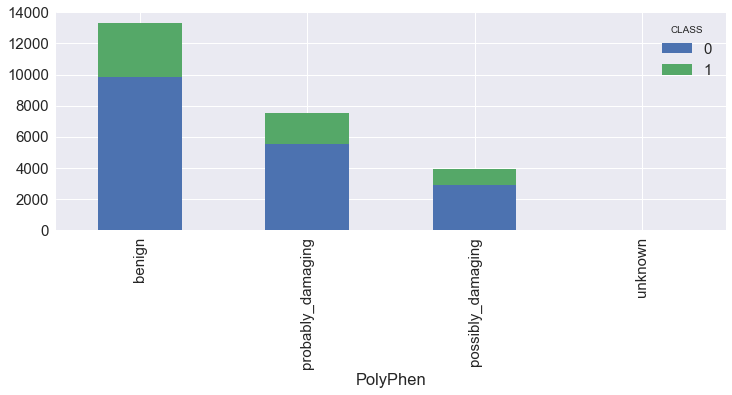

In [15]:
pp_ct = pd.crosstab(df.PolyPhen, df.CLASS, margins=True)
pp_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
pp_ct = pp_ct.sort_values(by='All', ascending=False)
pp_ct.drop('All', axis=1, inplace=True)

pp_ct.plot.bar(stacked=True, figsize=(12, 4));

Encode these features

In [16]:
df = pd.get_dummies(df, columns=['SIFT', 'PolyPhen'])

The dark blue box in in the heatmap highlights the negatvie correlation with the **allele frequency** features. Commomn alleles are less likely to pathogenic (cause disease), therefore most labs agree they should be benign.

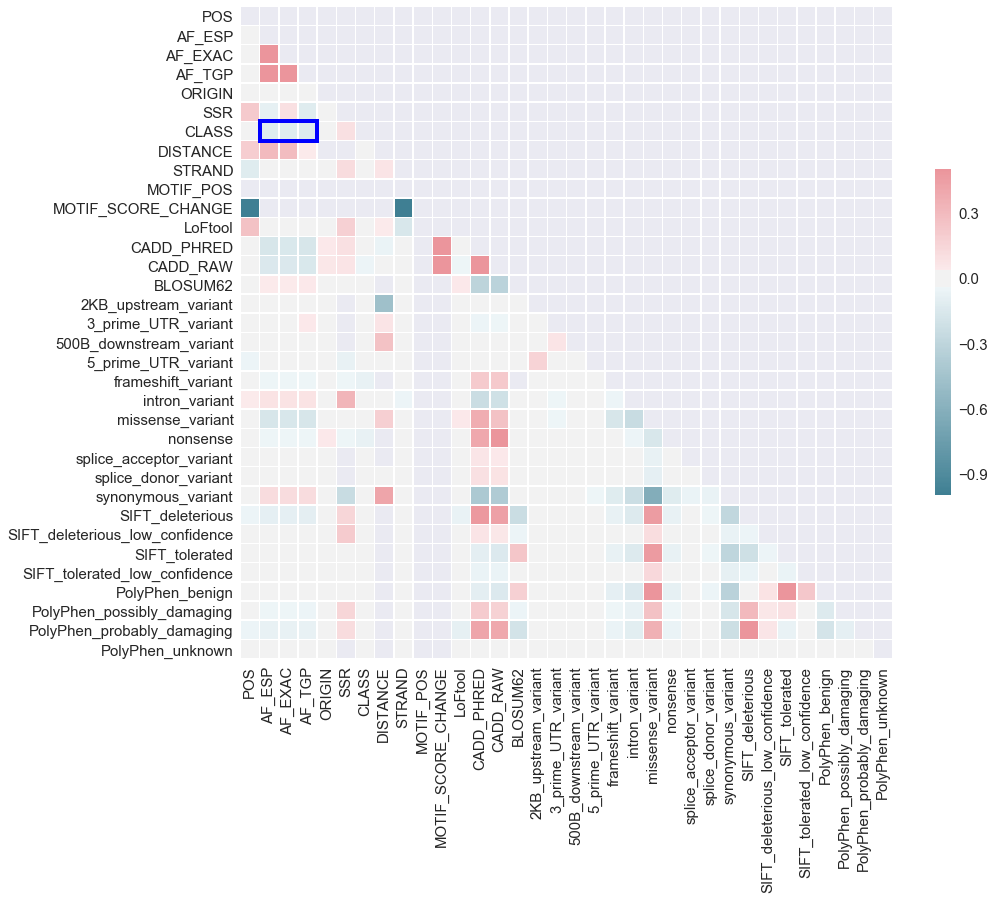

In [17]:
corr = df.corr()

import numpy as np
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True);

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5});


from matplotlib.patches import Rectangle

g.add_patch(Rectangle((1, 6), 3, 1, fill=False, edgecolor='blue', lw=4));

Most allele frequencies are very low

/anaconda3/envs/clinvar_py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


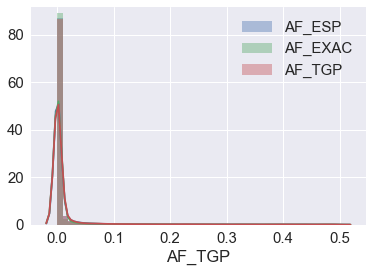

In [18]:
# most values are low
sns.distplot(df.AF_ESP, label="AF_ESP")
sns.distplot(df.AF_EXAC, label="AF_EXAC")
sns.distplot(df.AF_TGP, label="AF_TGP")
plt.legend();